In [1]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import (
    RandomForestClassifier,
    StackingClassifier,
    VotingClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier

from evaluation import get_cm_sklearn, print_metrics
from preprocessing import TrainingPreProcessor

RANDOM_STATE = 0

train_set = pd.read_csv("input/train.csv")

training_preprocessor = TrainingPreProcessor()
training_preprocessor.fit(train_set, ignore_columns=["CLIENTNUM"])

X, y = training_preprocessor.transform(train_set)
class_weight = training_preprocessor.class_weight
xgb_class_weight = compute_sample_weight(class_weight="balanced", y=y)

## Recuperação dos melhores modelos encontrados por gridsearch

In [8]:
logistic_regression_model = LogisticRegression(
    random_state=RANDOM_STATE,
    class_weight=class_weight,
    solver="saga",
    **{"C": 0.1, "max_iter": 1000, "penalty": "l2", "tol": 0.0001}
)

svc_model = SVC(
    random_state=RANDOM_STATE,
    class_weight=class_weight,
    **{"C": 1.0, "kernel": "rbf", "max_iter": 10000, "tol": 0.001}
)

rf_model = RandomForestClassifier(
    random_state=RANDOM_STATE,
    class_weight=class_weight,
    **{
        "criterion": "entropy",
        "max_depth": 7,
        "max_features": "sqrt",
        "n_estimators": 50,
    }
)
xgboost_classifier = XGBClassifier(
    seed=RANDOM_STATE,
    colsample_bytree=0.975,
    gamma=0.1,
    max_depth=4,
    min_child_weight=1,
    n_estimators=400,
    subsample=0.975,
)
catboost_classifier = CatBoostClassifier(
    random_state=RANDOM_STATE,
    class_weights=class_weight,
    **{"iterations": 300, "learning_rate": 0.05, "max_depth": 5}
)

test_set = pd.read_csv("input/test.csv")
X_test, y_test = training_preprocessor.transform(test_set)

## Treinando e avaliando um ensemle de votação

In [9]:
voting_ensemble = VotingClassifier(
    estimators=[
        ("logistic_regression", logistic_regression_model),
        ("svc", svc_model),
        ("random_forest", rf_model),
        ("xgboost", xgboost_classifier),
        ("catboost", catboost_classifier)
    ],
    voting="hard",
)
voting_ensemble.fit(X, y)
voting_ensemble.estimators_[3].fit(X,y, sample_weight=xgb_class_weight)

0:	learn: 0.6457202	total: 4.24ms	remaining: 1.27s
1:	learn: 0.5998631	total: 8.83ms	remaining: 1.31s
2:	learn: 0.5620370	total: 12.6ms	remaining: 1.25s
3:	learn: 0.5271172	total: 16.5ms	remaining: 1.22s
4:	learn: 0.4996344	total: 20.7ms	remaining: 1.22s
5:	learn: 0.4762069	total: 24.9ms	remaining: 1.22s
6:	learn: 0.4543191	total: 29ms	remaining: 1.21s
7:	learn: 0.4325027	total: 32.8ms	remaining: 1.2s
8:	learn: 0.4160071	total: 36.6ms	remaining: 1.18s
9:	learn: 0.4013742	total: 41ms	remaining: 1.19s
10:	learn: 0.3901922	total: 45.4ms	remaining: 1.19s
11:	learn: 0.3763558	total: 51.3ms	remaining: 1.23s
12:	learn: 0.3672238	total: 55.7ms	remaining: 1.23s
13:	learn: 0.3597148	total: 59.9ms	remaining: 1.22s
14:	learn: 0.3497061	total: 63.5ms	remaining: 1.21s
15:	learn: 0.3378960	total: 67.7ms	remaining: 1.2s
16:	learn: 0.3305672	total: 71.9ms	remaining: 1.2s
17:	learn: 0.3223792	total: 75.4ms	remaining: 1.18s
18:	learn: 0.3160604	total: 78.7ms	remaining: 1.16s
19:	learn: 0.3093247	total: 8

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.975, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Accuracy: 0.9511352418558736
Balanced Accuracy: 0.9424657065768135
F1: 0.9704035874439463
RoC AuC: 0.9424657065768135


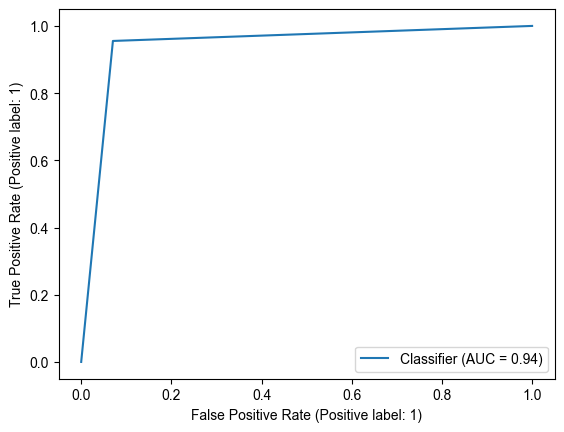

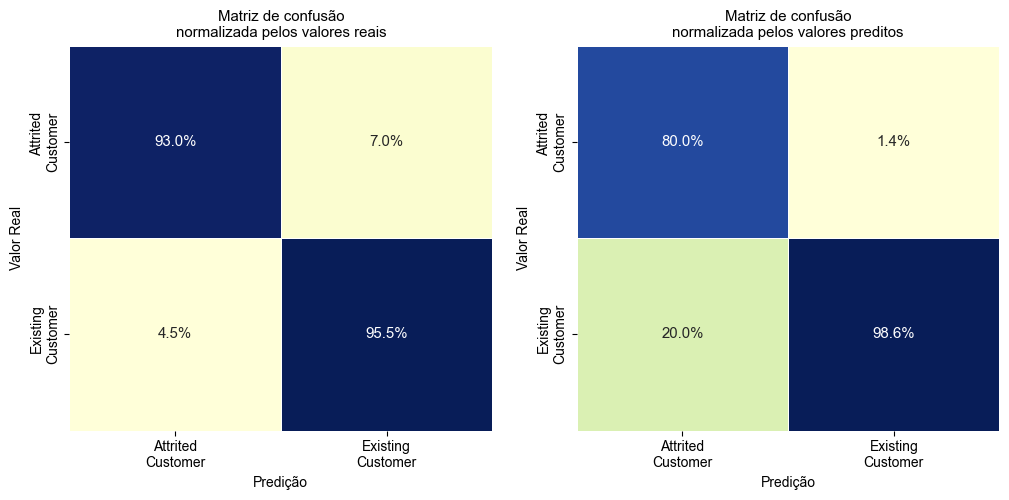

In [10]:
y_pred_test_voting = voting_ensemble.predict(X_test)

print_metrics(y_test, y_pred_test_voting)

get_cm_sklearn(
    y_test,
    y_pred_test_voting,
    labels=[
        "\n".join(label.split())
        for label in training_preprocessor.label_encoder.classes_
    ],
)

## Treinando e avaliando (sobre validação) um ensemle de empilhamento

In [18]:
logistic_regression_model.fit(X,y)
svc_model.fit(X,y)
rf_model.fit(X,y)
xgboost_classifier.fit(X,y, sample_weight=xgb_class_weight)
catboost_classifier.fit(X,y)

stacking_ensemble = StackingClassifier(
    estimators=[
        ("logistic_regression", logistic_regression_model),
        ("svc", svc_model),
        ("random_forest", rf_model),
        ("xgboost", xgboost_classifier),
        ("catboost", catboost_classifier)
    ],
    final_estimator=LogisticRegression(random_state=RANDOM_STATE),
    cv='prefit'
)
stacking_ensemble.fit(X, y)

0:	learn: 0.6457202	total: 4.97ms	remaining: 1.49s
1:	learn: 0.5998631	total: 8.9ms	remaining: 1.32s
2:	learn: 0.5620370	total: 13ms	remaining: 1.29s
3:	learn: 0.5271172	total: 18.5ms	remaining: 1.36s
4:	learn: 0.4996344	total: 22.4ms	remaining: 1.32s
5:	learn: 0.4762069	total: 26ms	remaining: 1.27s
6:	learn: 0.4543191	total: 30.2ms	remaining: 1.26s
7:	learn: 0.4325027	total: 35.6ms	remaining: 1.3s
8:	learn: 0.4160071	total: 40.4ms	remaining: 1.3s
9:	learn: 0.4013742	total: 45ms	remaining: 1.3s
10:	learn: 0.3901922	total: 50.9ms	remaining: 1.34s
11:	learn: 0.3763558	total: 55.3ms	remaining: 1.33s
12:	learn: 0.3672238	total: 59.7ms	remaining: 1.32s
13:	learn: 0.3597148	total: 64.4ms	remaining: 1.31s
14:	learn: 0.3497061	total: 68.4ms	remaining: 1.3s
15:	learn: 0.3378960	total: 72.1ms	remaining: 1.28s
16:	learn: 0.3305672	total: 76ms	remaining: 1.27s
17:	learn: 0.3223792	total: 80.1ms	remaining: 1.25s
18:	learn: 0.3160604	total: 84.2ms	remaining: 1.24s
19:	learn: 0.3093247	total: 87.7ms	

StackingClassifier(cv='prefit',
                   estimators=[('logistic_regression',
                                LogisticRegression(C=0.1,
                                                   class_weight={0: 3.1157692307692306,
                                                                 1: 0.5955741802676077},
                                                   max_iter=1000,
                                                   random_state=0,
                                                   solver='saga')),
                               ('svc',
                                SVC(class_weight={0: 3.1157692307692306,
                                                  1: 0.5955741802676077},
                                    max_iter=10000, random_state=0)),
                               ('random_forest',
                                RandomForestClassifier(class_weight={0: 3...
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=4,
                                              max_leaves=None,
                                              min_child_weight=1, missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=400, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...)),
                               ('catboost',
                                <catboost.core.CatBoostClassifier object at 0x0000027C76DA24D0>)],
                   final_estimator=LogisticRegression(random_state=0))

Accuracy: 0.9689042448173741
Balanced Accuracy: 0.9456516065395546
F1: 0.9814323607427057
RoC AuC: 0.9456516065395546


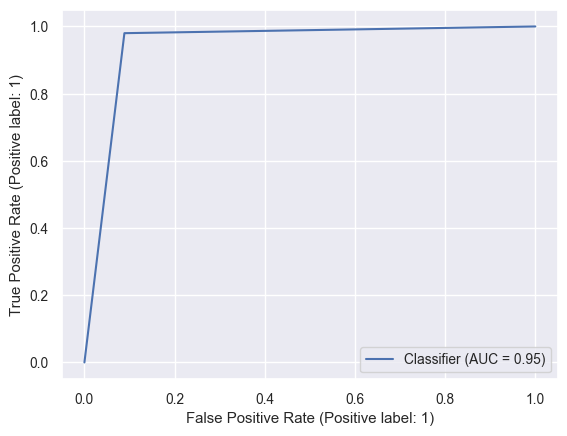

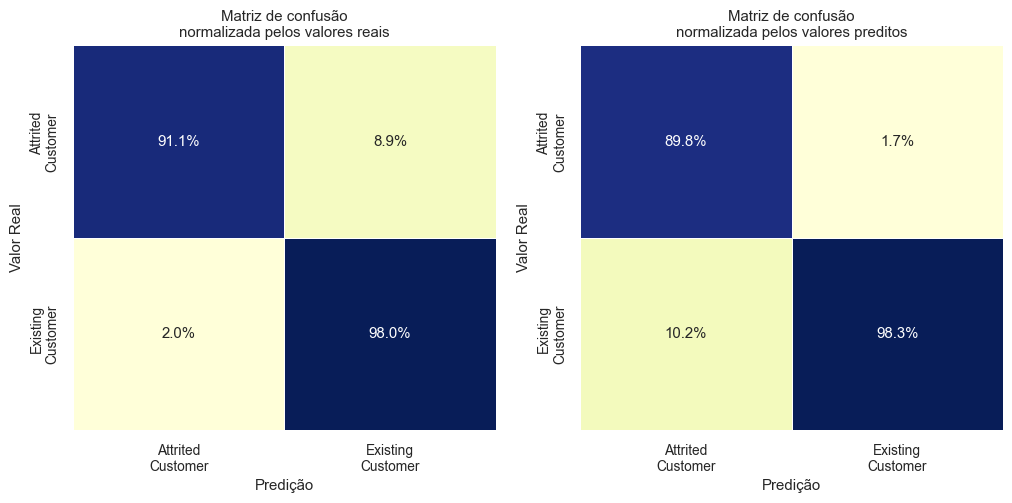

In [19]:
y_pred_test_stacking = stacking_ensemble.predict(X_test)

print_metrics(y_test, y_pred_test_stacking)

get_cm_sklearn(
    y_test,
    y_pred_test_stacking,
    labels=[
        "\n".join(label.split())
        for label in training_preprocessor.label_encoder.classes_
    ],
)